In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 3. Base Line

In [4]:
import pickle
with open('raw_data_20180811.pickle','rb') as handle:

    raw_data = pickle.load(handle)

In [5]:
kospi200 = pd.read_excel("C:\\Users\\axasd\\Downloads\\상장법인목록.xlsx")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)

In [6]:
code_dict = {
    i : j for i, j in zip(kospi200["회사명"], kospi200["종목코드"])
}

In [7]:
raw_data[code_dict["삼성전자"]].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,21400.0,21600.0,21300.0,21600.0,21.233131,13151350
2012-01-03,21860.0,22100.0,21840.0,22100.0,21.724644,16927750
2012-01-04,22100.0,22200.0,21500.0,21600.0,21.233131,17103700
2012-01-05,21460.0,21580.0,21100.0,21100.0,20.741627,17298400
2012-01-06,21120.0,21320.0,20600.0,20800.0,20.446722,18816250


In [8]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(sum_close_3 = raw_data[i].Close.rolling(window = 3).sum())
    raw_data[i] = raw_data[i].assign(sum_close_5 = raw_data[i].Close.rolling(window =5).sum())
    raw_data[i] = raw_data[i].assign(ma_5 = raw_data[i].Close.rolling(window = 5).mean())
    raw_data[i] = raw_data[i].assign(ma_10 = raw_data[i].Close.rolling(window = 10).mean())

In [9]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(pct_change = raw_data[i].Close.pct_change().fillna(0))

In [10]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(pct_change2 = raw_data[i].sum_close_3.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(pct_change3 = raw_data[i].sum_close_5.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(sencond_Y = np.where(raw_data[i]["pct_change2"].fillna(0)>=0, 1,0))
    raw_data[i] = raw_data[i].assign(third_Y = np.where(raw_data[i]["pct_change3"].fillna(0)>=0, 1,0))

In [20]:
raw_data["005930"]["pct_change"].values

array([ 0.        ,  0.02314815, -0.02262443, ..., -0.00852878,
       -0.00537634,  0.00648649])

In [26]:
Y=[]
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(Y = np.where(raw_data[i]["pct_change"].fillna(0), 4,np.nan))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [24]:
len(Y)

307394

In [71]:
Y = np.array([])

In [63]:
copy_keys = kospi200["종목코드"]

In [64]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].dropna(axis=0)

In [65]:
for i in copy_keys:
    if (len(raw_data[i]) < 252):
        del raw_data[i]

### Train, Test Split

In [13]:
train = {}
train_idx = {}
test = {}
test_idx = {}
for code, df in raw_data.items():
    train[code] = df.iloc[:int(len(df)*0.8)][["Open","ma_5", "ma_10"]]
    train_idx[code] = df.iloc[:int(len(df)*0.8)]["third_Y"]
    test[code] = df.iloc[int(len(df)*0.8):][["Open","ma_5", "ma_10"]]
    test_idx[code] = df.iloc[int(len(df)*0.8):]["third_Y"]

### Scale 조정

In [14]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
li = ["Open","ma_5", "ma_10"]
for code in raw_data.keys():
    train[code][li] = std_scaler.fit_transform(train[code][li].values)
    test[code][li] = std_scaler.fit_transform(test[code][li].values)

### model 호출

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression()
DTC_clf = DecisionTreeClassifier()
svm_clf = SVC()

### Predict

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
score_list = pd.DataFrame(columns=('LR','DT','SVM'))
CM = pd.DataFrame(columns=('LR','DT','SVM'))
roc_auc_score = pd.DataFrame(columns=('LR','DT','SVM'))

for i in raw_data.keys():
    a=[]
    a1=[]
    a2=[]
    X_train = train[i].values
    y_train = train_idx[i].values
    X_test = test[i].values
    y_test = test_idx[i].values
    for clf in (log_clf, DTC_clf, svm_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        a.append(accuracy_score(y_test, y_pred))
        y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
        a1.append([confusion_matrix(y_train, y_train_pred)])
        score=cross_val_predict(log_clf, X_train, y_train, cv=3,method="decision_function")
        fpr, tpr, thresholds = roc_curve(y_train, score)
        a2.append([auc(fpr, tpr)])
    score_list.loc[i] = a
    CM.loc[i] = a1
    roc_auc_score.loc[i] = a2

(array([ 1.,  0.,  0.,  0.,  0.,  7., 23., 59., 78., 29.]),
 array([0.50243902, 0.53609605, 0.56975308, 0.6034101 , 0.63706713,
        0.67072416, 0.70438118, 0.73803821, 0.77169524, 0.80535226,
        0.83900929]),
 <a list of 10 Patch objects>)

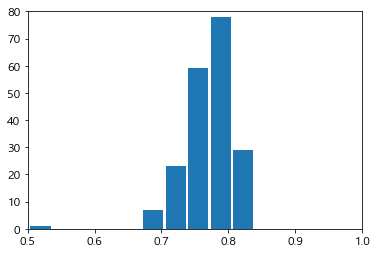

In [74]:
plt.axis([0.5,1,0,80])
plt.hist(score_list['LR'],bins=10,rwidth=0.9)

In [75]:
score_list.describe()

,LR,DT,SVM
count,197.000000,197.000000,197.000000
mean,0.771839,0.705076,0.739979
std,0.038494,0.042970,0.060694
min,0.502439,0.525424,0.448780
25%,0.752322,0.680412,0.718266
50%,0.777090,0.712074,0.755418
75%,0.795666,0.733746,0.780186
max,0.839009,0.795666,0.842105


여기까지해보자!

In [80]:
roc_auc_score

,LR,DT,SVM
006840,[0.8283479812043161],[0.8283479812043161],[0.8283479812043161]
027410,[0.8281579266077268],[0.8281579266077268],[0.8281579266077268]
138930,[0.837822083298133],[0.837822083298133],[0.837822083298133]
001040,[0.714527419542233],[0.714527419542233],[0.714527419542233]
079160,[0.7055667630429664],[0.7055667630429664],[0.7055667630429664]
000120,[0.8348034529706555],[0.8348034529706555],[0.8348034529706555]
097950,[0.8691970697208511],[0.8691970697208511],[0.8691970697208511]
005830,[0.8554536423521695],[0.8554536423521695],[0.8554536423521695]
000990,[0.7597957311184083],[0.7597957311184083],[0.7597957311184083]
114090,[0.8382686279238003],[0.8382686279238003],[0.8382686279238003]
